# SALT
\begin{equation*}
\frac{\partial V}{\partial t} = \Psi + \Omega
\end{equation*}

In [20]:
from dask.distributed import Client

client = Client("tcp://10.32.16.188:39415")
client

Client Scheduler: tcp://10.32.16.188:39415 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 25 Cores: 50 Memory: 287.50 GB


In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
xr.set_options(display_style='text')

In [3]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880
XG_left = 309
XG_right = 881
YG_upper = 96

In [4]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat), YG=slice(lower_lat, YG_upper))
lon_range = dict(XC=slice(left_lon, right_lon), XG=slice(left_lon, XG_right))

In [5]:
#set the boundaries
lat_range_noface = dict(YC=slice(lower_lat, upper_lat))
lon_range_noface = dict(XC=slice(left_lon, right_lon))

In [19]:
base_dir = 'pangeo-tmp/stb2145/SOSE/datasets/'
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr'))
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tns.zarr'))
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_slt_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_vel.zarr'))
ds = xr.merge([ds_tns, ds_slt, ds_vel])
ds

<xarray.Dataset>
Dimensions:                   (XC: 570, XG: 571, YC: 95, YG: 96, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 295.08334 295.25 ... 29.75 29.916668
  * YC                        (YC) float32 -77.87497 -77.7083 ... -62.2083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                        (XG) float32 295.0 295.1667 ... 29.833334 30.0
  * YG                        (YG) float32 -77.9583 -77.79163 ... -62.124966
  * Zl                        (Zl) float32 0.0 -10.0 -21.0 ... -5200.0 -5450.0
Data variables:
    ETAN                      (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    SALT                      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    THETA                     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    UVEL                      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 95, 571), meta=np.ndarray>
    VVEL                      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 96, 570), meta=np.ndarray>
    WSLTMASS                  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    WTHMASS                   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    WVEL                      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surForcS                  (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    surForcT                  (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>

In [21]:
coords_no_polynya = coords.isel(time=slice(72,  -1))
ds_no_polynya = ds.isel(time=slice(72,  -1))

In [22]:
ds_no_polynya.time

<xarray.DataArray 'time' (time: 365)>
array(['2006-01-01T00:00:00.000000000', '2006-01-06T00:00:00.000000000',
       '2006-01-11T00:00:00.000000000', ..., '2010-12-16T00:00:00.000000000',
       '2010-12-21T00:00:00.000000000', '2010-12-26T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-26
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [23]:
ds = ds.chunk({'time':5})
ds.nbytes/1e9

52.322753328

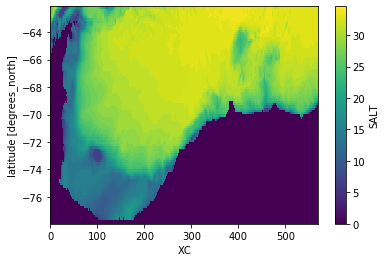

In [24]:
#can't plot w dask cluster
ds.SALT.mean(dim=['time', 'Z']).drop('XC').plot()

In [25]:
terms = ['conv_horiz_adv_flux_SLT', 'conv_horiz_diff_flux_SLT',
         'conv_vert_adv_flux_SLT', 'conv_vert_diff_flux_SLT',
         'surface_flux_conv_SLT', 'lin_fs_correction_SLT']

In [26]:
total = sum(ds[term] for term in terms)

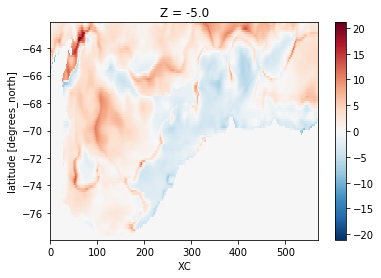

In [27]:
total.isel(Z=0).mean(dim='time').drop('XC').plot()

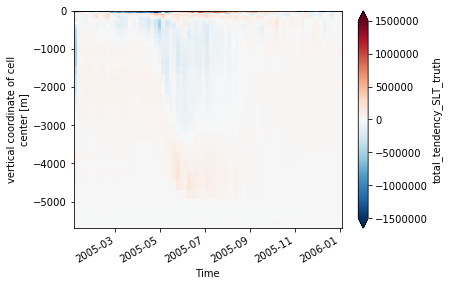

In [36]:
ds.total_tendency_SLT_truth.isel(time=slice(0,73)).sum(dim=['XC', 'YC']).plot(y='Z', vmax=1.5e6)

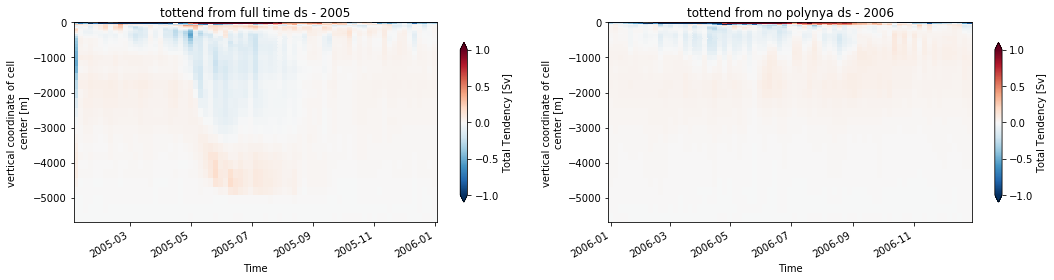

In [41]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))
(ds/1e6).total_tendency_SLT_truth.isel(time=slice(0,73)).sum(dim=['XC', 'YC']).plot(y='Z', ax=ax0, 
                                              cbar_kwargs={'shrink':0.8, 'label':'Total Tendency [Sv]'}, vmax=1)
ax0.set_title('tottend from full time ds - 2005')

(ds_no_polynya/1e6).total_tendency_SLT_truth.isel(time=slice(0,73)).sum(dim=['XC', 'YC']).plot(y='Z', ax=ax1,
                                                         cbar_kwargs={'shrink':0.8, 'label':'Total Tendency [Sv]'}, vmax=1)
ax1.set_title('tottend from no polynya ds - 2006')

plt.tight_layout();